In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Smokum&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Smokum; color:#ff33aa; font-size:35px;'>
    %s</h1>"""%str))

In [2]:
dhtml('Code Modules & Settings')

In [3]:
import os,numpy as np,pandas as pd
import pylab as pl,seaborn as sn,tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing import image as kimg
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as tkl
from tensorflow.keras import callbacks as tkc
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True

In [4]:
dhtml('Mixed Data')

In [5]:
n1=600
classes=['plane','car','bird','cat','deer',
         'dog','frog','horse','ship','truck']
(x,y),(_,_)=cifar10.load_data()
x=np.array(x,dtype='float32')/255
y=y.reshape(-1)
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
shuffle_ids=shuffle_ids[:n1]
x,y=x[shuffle_ids],y[shuffle_ids]

170500096/170498071 [==============================] - 11s 0us/step


[(600, 32, 32, 3), dtype('float32'), (600,), dtype('uint8')]
Label:  horse


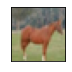

In [6]:
print([x.shape,x.dtype,y.shape,y.dtype])
print('Label: ',classes[y[1]])
pl.figure(figsize=(1,1))
pl.xticks([]); pl.yticks([])
pl.imshow(x[1]);

In [7]:
img_size=32
manners=['pictogram','contour','sketch']
objects=['flower','bird','butterfly','tree',
         'plane','crane','dog','horse','deer',
         'truck','car','cat','frog','ship']
fpath='../input/art-pictogram/pictogram/'
flist=sorted(os.listdir(fpath))
def path_to_tensor(img_path,fpath):
    img=kimg.load_img(fpath+img_path,
                      target_size=(img_size,img_size))
    x=kimg.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths,fpath):
    tensor_list=[path_to_tensor(img_path,fpath) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)
labels1=np.array([int(el[:2]) for el in flist],
                 dtype='int8')-1
labels2=np.array([int(el[3:6]) for el in flist],
                 dtype='int8')-1
images=np.array(paths_to_tensor(flist,fpath=fpath))/255
n2=len(labels1[labels1==0])
images=images[:n2]; labels2=labels2[:n2]
cond=np.where([l in classes for l in objects])[0]
cond2=np.where([l in cond for l in labels2])
images=images[cond2]; labels=labels2[cond2]
rd={1:2,4:0,6:5,7:7,8:4,9:9,10:1,11:3,12:6,13:8}
labels=np.array([rd.get(x,x) for x in labels],
                dtype='int8')

100%|██████████| 1351/1351 [00:02<00:00, 573.72it/s]


[(583, 32, 32, 3), dtype('float32'), (583,), dtype('int8')]
Label:  plane


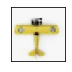

In [8]:
print([images.shape,images.dtype,
       labels.shape,labels.dtype])
print('Label: ',classes[labels[100]])
pl.figure(figsize=(1,1))
pl.xticks([]); pl.yticks([])
pl.imshow(images[100]);

In [9]:
x=np.vstack([x,images])
y=np.hstack([y,labels])
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
print([x.shape,x.dtype,y.shape,y.dtype])

[(1183, 32, 32, 3), dtype('float32'), (1183,), dtype('int16')]


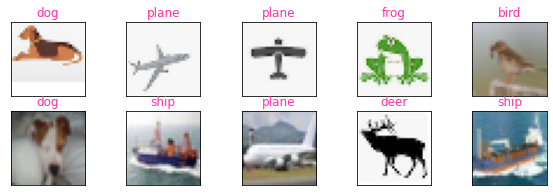

In [10]:
fig=pl.figure(figsize=(10,3))
randch=np.random.choice(x_test.shape[0],
                        size=10,replace=False)
for i,idx in enumerate(randch):
    ax=fig.add_subplot(2,5,i+1,
                       xticks=[],yticks=[])
    ax.imshow(x_test[idx])
    true_idx=y_test[idx]
    ax.set_title(classes[true_idx],color="#ff33aa")

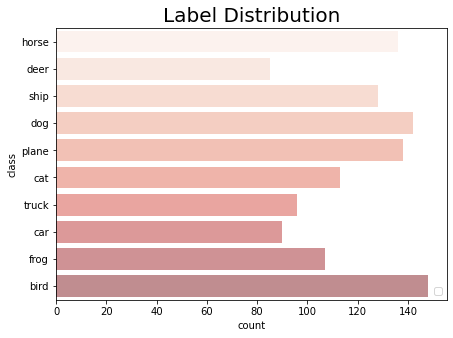

In [11]:
df=pd.DataFrame(y,columns=['label'])
df['class']=[classes[l] for l in y]
pl.figure(figsize=(7,5))
sn.countplot(y='class',data=df,
             palette='Reds',alpha=.5)
ti='Label Distribution'
pl.title(ti,fontsize=20); pl.legend(loc=4);

In [12]:
dhtml('NN Examples')

In [13]:
def cnn_model():
    model=Sequential()
    model.add(tkl.Conv2D(32,(5,5),padding='same',
                         input_shape=x_train.shape[1:]))
    model.add(tkl.Activation('relu'))
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.Conv2D(196,(5,5)))
    model.add(tkl.Activation('relu'))    
    model.add(tkl.MaxPooling2D(pool_size=(2,2)))
    model.add(tkl.Dropout(.25))
    model.add(tkl.GlobalAveragePooling2D())    
    model.add(tkl.Dense(512,activation='tanh'))
    model.add(tkl.Dropout(.25))         
    model.add(tkl.Dense(128,activation='tanh'))
    model.add(tkl.Dropout(.25)) 
    model.add(tkl.Dense(10))
    model.add(tkl.Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='nadam',metrics=['accuracy'])
    return model

In [14]:
cnn_model=cnn_model()
fw='weights.best.hdf5'
early_stopping=tkc.EarlyStopping(monitor='val_loss',
                                 patience=20,verbose=2)
checkpointer=tkc.ModelCheckpoint(filepath=fw,verbose=2,
                                 save_best_only=True)
lr_reduction=tkc.ReduceLROnPlateau(monitor='val_loss',verbose=2,
                                   patience=5,factor=.8)
history=cnn_model.fit(x_train,y_train,epochs=100,
                      batch_size=64,verbose=2,
                      validation_data=(x_valid,y_valid),
                      callbacks=[checkpointer,early_stopping,lr_reduction])

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.28486, saving model to weights.best.hdf5
15/15 - 2s - loss: 2.3095 - accuracy: 0.1172 - val_loss: 2.2849 - val_accuracy: 0.1525 - lr: 0.0010
Epoch 2/100

Epoch 00002: val_loss improved from 2.28486 to 2.22985, saving model to weights.best.hdf5
15/15 - 2s - loss: 2.2735 - accuracy: 0.1394 - val_loss: 2.2299 - val_accuracy: 0.1695 - lr: 0.0010
Epoch 3/100

Epoch 00003: val_loss improved from 2.22985 to 2.20179, saving model to weights.best.hdf5
15/15 - 2s - loss: 2.2496 - accuracy: 0.1531 - val_loss: 2.2018 - val_accuracy: 0.1525 - lr: 0.0010
Epoch 4/100

Epoch 00004: val_loss did not improve from 2.20179
15/15 - 2s - loss: 2.2116 - accuracy: 0.1721 - val_loss: 2.2046 - val_accuracy: 0.1441 - lr: 0.0010
Epoch 5/100

Epoch 00005: val_loss did not improve from 2.20179
15/15 - 2s - loss: 2.1688 - accuracy: 0.1816 - val_loss: 2.2734 - val_accuracy: 0.1186 - lr: 0.0010
Epoch 6/100

Epoch 00006: val_loss improved from 2.20179 to 2.13207

In [15]:
cnn_model.load_weights(fw)
cnn_model.evaluate(x_test,y_test)

4/4 [==============================] - 0s 12ms/step - loss: 1.3639 - accuracy: 0.5169


[1.3638609647750854, 0.5169491767883301]